<a href="https://colab.research.google.com/github/kaiu85/stable-diffusion-workshop/blob/main/Cool_Applications/inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-painting pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to do text-guided in-painting with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/kaiu85/stable-diffusion-workshop/blob/main/stable_diffusion.ipynb).

First, let us check again, if our instance is using a (GPU) graphics card to accelerate our computations. If yes, then !nvidia-smi should print out some informations, such as GPU type (likely Tesla T4), GPU memory (around 15GB), ... 
If this command fails, you can change the runtime settings via "Runtime -> Change runtime type" (German: "Laufzeit -> Laufzeittyp ändern") and select "GPU".

In [1]:
!nvidia-smi

Thu Nov 17 16:15:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now let us install the fantastic diffusers library and some other required libraries again.

In [2]:
!pip install -qq -U diffusers==0.6.0 transformers ftfy gradio
!pip install git+https://github.com/huggingface/diffusers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-509jj6mu
  Running command git clone -q https://github.com/huggingface/diffusers.git /tmp/pip-req-build-509jj6mu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for diffusers: filename=diffusers-0.8.0.dev0-py3-none-any.whl size=380294 sha256=8a047d2d7fcc2bba48f0b35be4e5038173f4f5fe8cb86b2dd2c666c075ca9c1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-fc03rdx5/wheels/02/d2/24/9d4a75289c359ffceca56b42aecb8e8fbf659c455bcd4d2eca
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.6.0
    Uninstalling diffusers-0.6.0:
      Successfully uninstalled diffusers-0.6.0


Remember, that for in-painting, i.e. "filling holes" in a picture using a diffusion-model, the U-net has to be trained differently: It now also has to take the given image parts as an additional input (together with the text prompt), so that it can generate the missing parts consistently.

In this post we'll use the `runwayml/stable-diffusion-inpainting` model released by Runwayml so you'll need to  visit [its Huggingface model-card](https://huggingface.co/runwayml/stable-diffusion-inpainting) while being logged-in, read the license and tick the checkbox if you agree. 

If you accept the license while being logged-in with an account, for which you already have created an access token, you will be able to just use this token to log into Hugging face and download the pre-trained model. You can generate new tokens and view your existing tokens here: https://huggingface.co/settings/tokens.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Now let's import the ``StableDiffusionInpaintPipeline`` and some other useful packages.

In [9]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from PIL import Image
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

Now we can generate an inpainting pipeline object and move it to the GPU ( ```
device = "cuda"``).

In [5]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

As in previous notebooks, we define a helper function "image_grid", which just lets us display multiple images in a nice grid view.

In [6]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In the next code cells, we download an image and a mask image. The mask image tells the pipeline, which pixels of the image should be replaced by samples from the latent-diffusion model (white) and which pixels should be kept (black).

In [7]:
# Dowload the image
!wget https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png

--2022-11-17 16:30:55--  https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404753 (395K) [image/png]
Saving to: ‘overture-creations-5sI6fQgYIuo.png’

overture-creations- 100%[===================>] 395.27K  --.-KB/s    in 0.05s   

2022-11-17 16:30:55 (8.17 MB/s) - ‘overture-creations-5sI6fQgYIuo.png’ saved [404753/404753]



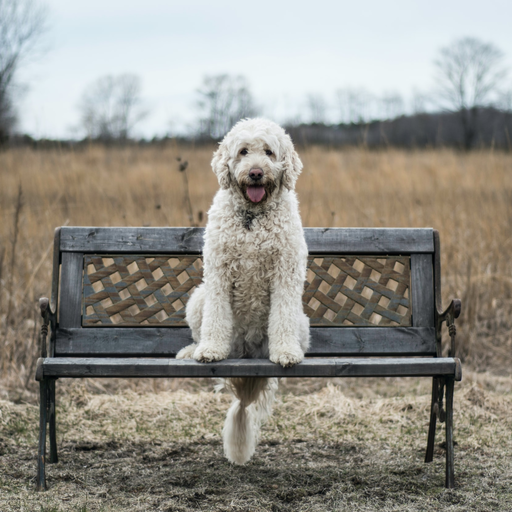

In [11]:
# Preprocess and display the image
filename = 'overture-creations-5sI6fQgYIuo.png'

image = Image.open(filename).convert("RGB")
image = image.resize((512, 512))
image

In [12]:
# Download the mask image
!wget https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png

--2022-11-17 16:31:32--  https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12106 (12K) [image/png]
Saving to: ‘overture-creations-5sI6fQgYIuo_mask.png’

overture-creations- 100%[===================>]  11.82K  --.-KB/s    in 0s      

2022-11-17 16:31:32 (84.7 MB/s) - ‘overture-creations-5sI6fQgYIuo_mask.png’ saved [12106/12106]



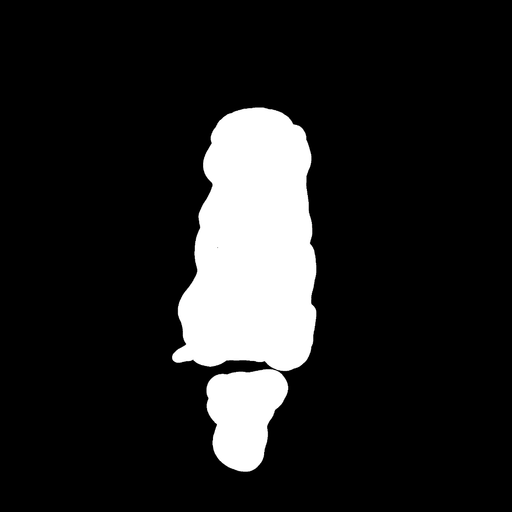

In [13]:
# Preprocess and display the mask image
filename = 'overture-creations-5sI6fQgYIuo_mask.png'

mask_image = Image.open(filename).convert("RGB")
mask_image = mask_image.resize((512, 512))
mask_image

Remember that the mask image tells the pipeline, which pixels of the image should be replaced (white) and which pixels should be kept (black).

Now let's define a prompt, which guides the generation process and see, how the generated results look like for three (``num_samples``) samples.

In [14]:
prompt = "a tucan sitting on a bench"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

To compare the in-painted images with the original image, we add the original images as first item to the list ``images``.

In [15]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

Now we display the list of images using our ``image_grid`` function (with a single row).

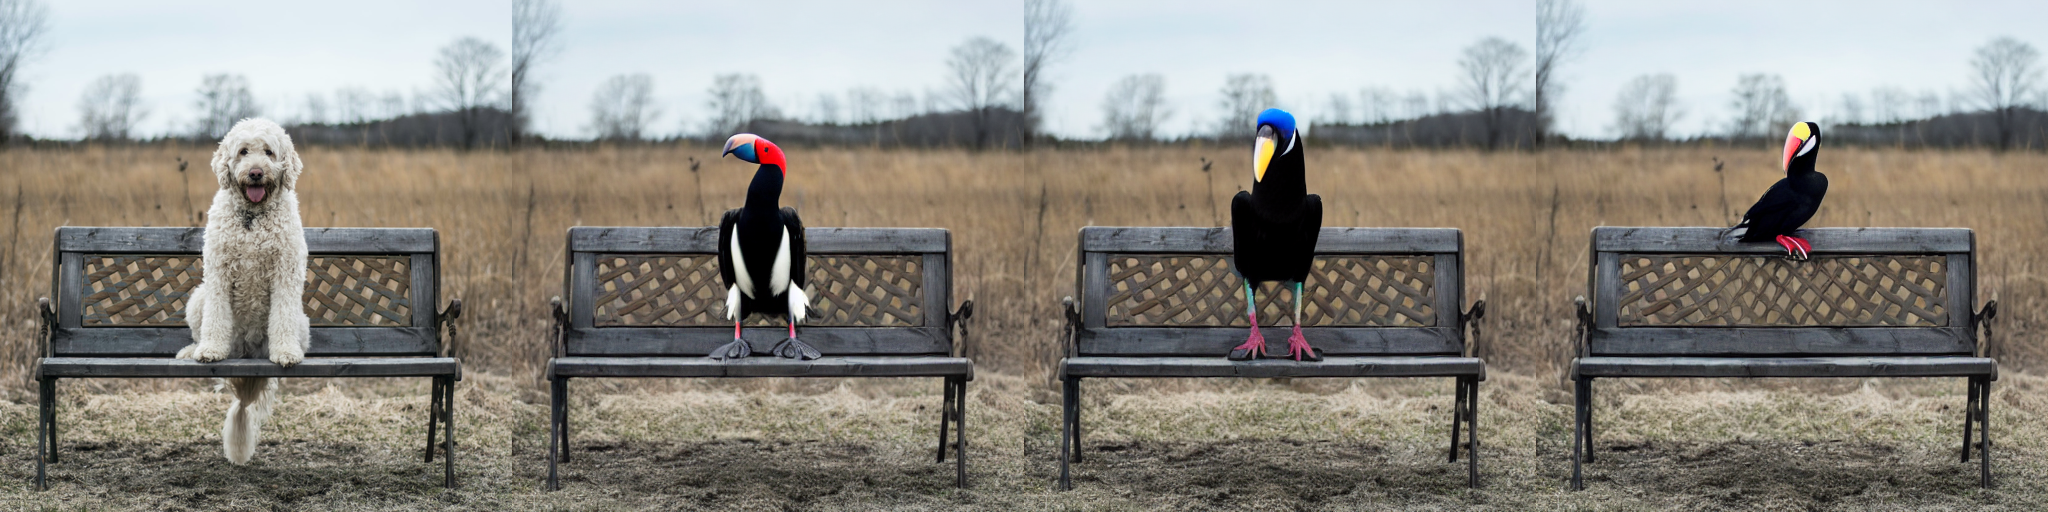

In [16]:
image_grid(images, 1, num_samples + 1)

Again, you can just use the file explorer to the left (   )-Icon)

### Gradio Demo

In [ ]:
def predict(dict, prompt):
  image =  dict['image'].convert("RGB").resize((512, 512))
  mask_image = dict['mask'].convert("RGB").resize((512, 512))
  images = pipe(prompt=prompt, image=image, mask_image=mask_image).images
  return(images[0])

In [ ]:
gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting',
    inputs=[
        gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch(debug=True)